<a href="https://colab.research.google.com/github/jjonhwa/DeepLearning.AI-TensorFlow/blob/main/37_S%2BP_Week_4_Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time,series, format = '-', start = 0, end = None) :
  plt.plot(time[start : end], series[start : end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope = 0) :
  return slope * time

def seasonal_pattern(season_time) :
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 *np.pi),
                  1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude = 1, phase = 0) :
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None) :
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
series += noise(time, noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer) :
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda x : x.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda x : (x[:-1], x[1:]))
  ds = ds.batch(batch_size).prefetch(1)

  return ds

In [ ]:
def model_forecast(model, series, window_size) :
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda x: x.batch(window_size))
  ds = ds.batch(32).prefetch(1)

  forecast = model.predict(ds)
  return forecast

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Lambda, Conv1D
from tensorflow.keras.optimizers import SGD

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size = 128, shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    Conv1D(filters = 32, kernel_size = 5,
           strides = 1, padding = 'causal',
           activation = 'relu',
           input_shape = [None, 1]),
    Bidirectional(LSTM(32, return_sequences = True)),
    Bidirectional(LSTM(32, return_sequences = True)),
    Dense(1),
    Lambda(lambda x : x * 200)
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch / 20)
)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = SGD(lr = 1e-8, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_scheduler], verbose = 0)

(1e-08, 0.0001, 0.0, 30.0)

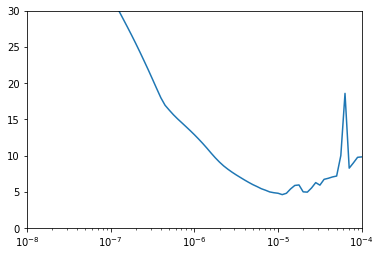

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    Conv1D(filters = 32, kernel_size = 3,
           strides = 1, padding = 'causal',
           activation = 'relu',
           input_shape = [None, 1]),
    LSTM(32, return_sequences = True),
    LSTM(32, return_sequences = True),
    Dense(1),
    Lambda(lambda x: x * 200)
])

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = SGD(lr = 1e-5, momentum = 0.9),
              metrics = ['mae'])

history = model.fit(dataset, epochs = 500, verbose = 0)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

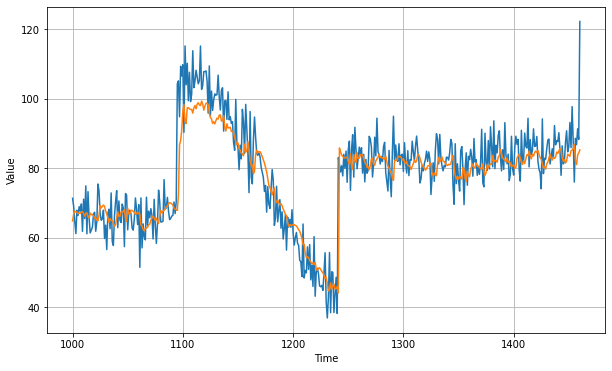

In [ ]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.159543

<Figure size 432x288 with 0 Axes>

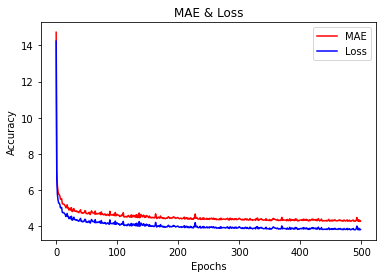

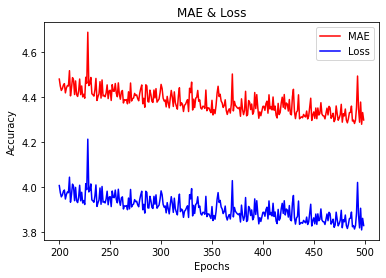

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE & Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend('Acuuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE & Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()